In [1]:
import torch
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import Models.Models

In [3]:
import main
import Utils.Dataset as ds
import Utils.utils as utils

Image Classes Paths: ['/Users/Andrew/ml/ImageRecognitionOOTB/Data/LilUziVert', '/Users/Andrew/ml/ImageRecognitionOOTB/Data/TravisScott'], Classes: ['LilUziVert', 'TravisScott']


In [4]:
image_classes_paths, classes = utils.get_classes_and_paths()
print(f'Image Classes Paths: {image_classes_paths}, Classes: {classes}')

Image Classes Paths: ['/Users/Andrew/ml/ImageRecognitionOOTB/Data/LilUziVert', '/Users/Andrew/ml/ImageRecognitionOOTB/Data/TravisScott'], Classes: ['LilUziVert', 'TravisScott']


In [5]:
net = Models.Models.vgg16(len(classes))
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [15]:
dataset = ds.DataSetCreator(image_classes_paths)

In [18]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)
dataiter = iter(data_loader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


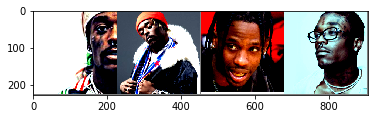

LilUziVert LilUziVert TravisScott LilUziVert


In [19]:
utils.show_image(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[int(labels[j].item())] for j in range(4)))

In [9]:
outputs = net(images)
print(outputs)

tensor([[-0.5280,  0.1958],
        [ 0.0196, -0.2006],
        [-0.1878, -0.3931],
        [ 0.0556,  0.0656]], grad_fn=<ThAddmmBackward>)
